## Purpose: To find similarities between courses
- In the class survey conducted, 4 questions about classes were asked
- Data Analysis is required to find similarities between the classes

In [ ]:
import pandas as pd  
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# this cell has not been run to keep sensitve survey info private
class_df = pd.read_csv('SYDE 1A Class Profile Questions.csv')

## Get the correct columns
- 4 questions x 7 courses = 28 total columns

In [3]:
course_list = ['101', '101L', '111', '113', '121', '161', '181']
all_course_cols = []
for course in course_list:
    current_course_cols = [col for col in class_df.columns if course in col and col not in all_course_cols]
    all_course_cols += current_course_cols
all_course_cols

['What was your final grade for 101?',
 'What was your final grade for 101L?',
 'How useful did you find each of the 1A courses to be? [101L]',
 'How useful did you find each of the 1A courses to be? [101]',
 'How difficult did you find each 1A course to be? [101L]',
 'How difficult did you find each 1A course to be? [101]',
 'Roughly what percentage of lectures did you watch for each course?? [101L]',
 'Roughly what percentage of lectures did you watch for each course?? [101]',
 'What was your final grade for 111? ',
 'How useful did you find each of the 1A courses to be? [111]',
 'How difficult did you find each 1A course to be? [111]',
 'Roughly what percentage of lectures did you watch for each course?? [111]',
 'What was your final grade for 113?',
 'How useful did you find each of the 1A courses to be? [113]',
 'How difficult did you find each 1A course to be? [113]',
 'Roughly what percentage of lectures did you watch for each course?? [113]',
 'What was your final grade for 121

In [ ]:
course_df = class_df[all_course_cols]
course_df.head()

In [ ]:
diff_cols = [col for col in course_df.columns if col.startswith('How difficult')]
course_df[diff_cols].isna().sum()

In [ ]:
course_df.info()

## Clean Data
- There is missing data that must be dealt with
- Some data is of type object and it must be label encoded

In [7]:
def handle_course_cols(row):
    """
    Turn each of the categorical columns that have to do with courses into integers either through mappings or string manipulation
    """
    # deal with the empty 181 by placing it as a value of 2 (same as neutral)
    usefulness_mappings = {'Useless': 0, 'Somewhat Useless': 1,'Neutral': 2, 'Somewhat Useful': 3,'Very Useful': 4, np.NaN: 2}
    difficulty_mappings = {'Easy': 4, 'Somewhat Easy': 3, 'Neutral': 2, 'Somewhat Difficult': 1, 'Very Difficult': 0, np.NaN: 2} 
    class_list = ['[101]', '[101L]', '[111]', '[113]', '[121]', '[161]', '[181]']   

    for syde_class in class_list:
        row[f'How useful did you find each of the 1A courses to be? {syde_class}'] = usefulness_mappings[row.get(f'How useful did you find each of the 1A courses to be? {syde_class}')]
        row[f'How difficult did you find each 1A course to be? {syde_class}'] = difficulty_mappings[row.get(f'How difficult did you find each 1A course to be? {syde_class}')]

        if type(row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}']) != float:
             row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}'] = int(row.get(f'Roughly what percentage of lectures did you watch for each course?? {syde_class}')[:-1])
        else:
            row[f'Roughly what percentage of lectures did you watch for each course?? {syde_class}'] = 50
    
    return row

In [ ]:
course_df = course_df.apply(handle_course_cols, axis=1)
course_df.head()

In [ ]:
course_df.info()

In [ ]:
students_with_grades = course_df['What was your final grade for 101?'].notnull()
# remove na
course_df = course_df[students_with_grades]
course_df

## Transform the shape of the data
- To make the data useable, it must be pivoted so that the data is indexed by person **and by course**

In [ ]:
# create a new df to store the data
outer_student_index = []
inner_course_index = []

for stu_id in course_df.index:
    outer_student_index += [stu_id] * 7
    inner_course_index += ['101', '101L', '111', '113', '121', '161', '181']
# print(len(outer_student_index), len(inner_course_index))
index = [
    np.array(outer_student_index),
    np.array(inner_course_index)
]
index


In [ ]:
pivoted_course_df = pd.DataFrame(index=index, columns=['avg', 'lect_watched', 'difficulty', 'usefulness'])
pivoted_course_df.head(20)

In [13]:
def populate_pivoted_df(row, pivoted_df):
    student_index = row.name
    for col in row.index:
        course = col[-5:-1].lstrip('[').rstrip('?').lstrip().rstrip()
        primary_key = (student_index, course)

        if col.startswith('What was'):
            pivoted_df.loc[primary_key, 'avg'] = row[col]
        elif col.startswith('How useful'):
            pivoted_df.loc[primary_key, 'usefulness'] = row[col]
        elif col.startswith('How difficult'):
            pivoted_df.loc[primary_key, 'difficulty'] = row[col]
        else:
             pivoted_df.loc[primary_key, 'lect_watched'] = row[col]


In [ ]:
course_df.apply(populate_pivoted_df, axis=1, args=(pivoted_course_df,))

pivoted_course_df.head(20)

In [15]:
pivoted_course_df.isna().sum()

avg             0
lect_watched    0
difficulty      0
usefulness      0
dtype: int64

In [16]:
pivoted_course_df.shape

(637, 4)

## Create machine learning functions
- Use PCA and TSNE for visualizations
- Make functions for both PCA and TSNE to easily apply these algorithms

In [17]:
from sklearn.decomposition import PCA

def create_pca(df: pd.DataFrame, n_components=2) -> pd.DataFrame:
    pca = PCA(n_components=n_components)
    pca_model = pd.DataFrame(pca.fit_transform(df))
    pca_model = pca_model.join(pd.DataFrame(inner_course_index, columns=['course']))
    return pca_model

In [18]:
from sklearn.manifold import TSNE

def create_tsne(df: pd.DataFrame, perplexity=30) -> pd.DataFrame:
    tsne = TSNE(n_components=2, n_jobs=-1, perplexity=perplexity)
    tsne_model = pd.DataFrame(tsne.fit_transform(df))
    tsne_model = tsne_model.join(pd.DataFrame(inner_course_index, columns=['course']))
    return tsne_model

In [19]:
def plot_courses(df: pd.DataFrame, title: str) -> sns.scatterplot:
    """ Graph the courses after PCA/TSNE was applied

    Args:
        df: The datafame containing the dimensions and the corresponding course labels
        title: The title for the graph
    
    Returns:
        A scatterplot of the data
    """
    sns.set_style('darkgrid')
    if 'tsne' in title.lower():
        point_size=100
    else:
        point_size=150

    try:
        fig, ax = plt.subplots(figsize=(20, 20))
        sns.scatterplot(x=df[0], y=df[1], hue=df['course'], ax=ax, s=point_size, style=df['course'])
        ax.set_xlabel('Dim 1', fontsize=35)
        ax.set_ylabel('Dim 2', fontsize=35)
        ax.set_title(title, fontsize=50)
        ax.legend(fontsize=30, markerscale=2)

        return ax
    except Exception as e:
        print(f'Error {e}')

In [ ]:
reset_pivoted_df = pivoted_course_df.reset_index()
reset_pivoted_df.rename(columns={'level_0': 'student_id', 'level_1': 'course_id'}, inplace=True)
reset_pivoted_df

## Scale the data
- Since TSNE and PCA are both sensitive to spacial dimensions, scale the data

In [ ]:
features = ['avg', 'lect_watched', 'difficulty', 'usefulness']
scaled_pivoted_df = reset_pivoted_df[features]
scaled_pivoted_df = (scaled_pivoted_df - scaled_pivoted_df.mean(axis=0)) / scaled_pivoted_df.std(axis=0)
scaled_pivoted_df

In [ ]:
reset_pivoted_df[features] = (reset_pivoted_df[features] - reset_pivoted_df[features].mean(axis=0)) / reset_pivoted_df[features].std(axis=0)
reset_pivoted_df

In [23]:
tnse_scaled_df = create_tsne(scaled_pivoted_df, perplexity=25)
tnse_scaled_df

0          1 course
0   -15.730416 -37.332100    101
1     6.996901 -25.238644   101L
2     6.575552  13.047177    111
3    -4.584672 -12.516791    113
4    -0.777846  -0.494582    121
..         ...        ...    ...
632  30.280432  -6.373179    111
633  30.805033  -7.036754    113
634 -11.607433 -10.163023    121
635  25.769445  -2.163265    161
636  30.930464  -5.743870    181

[637 rows x 3 columns]

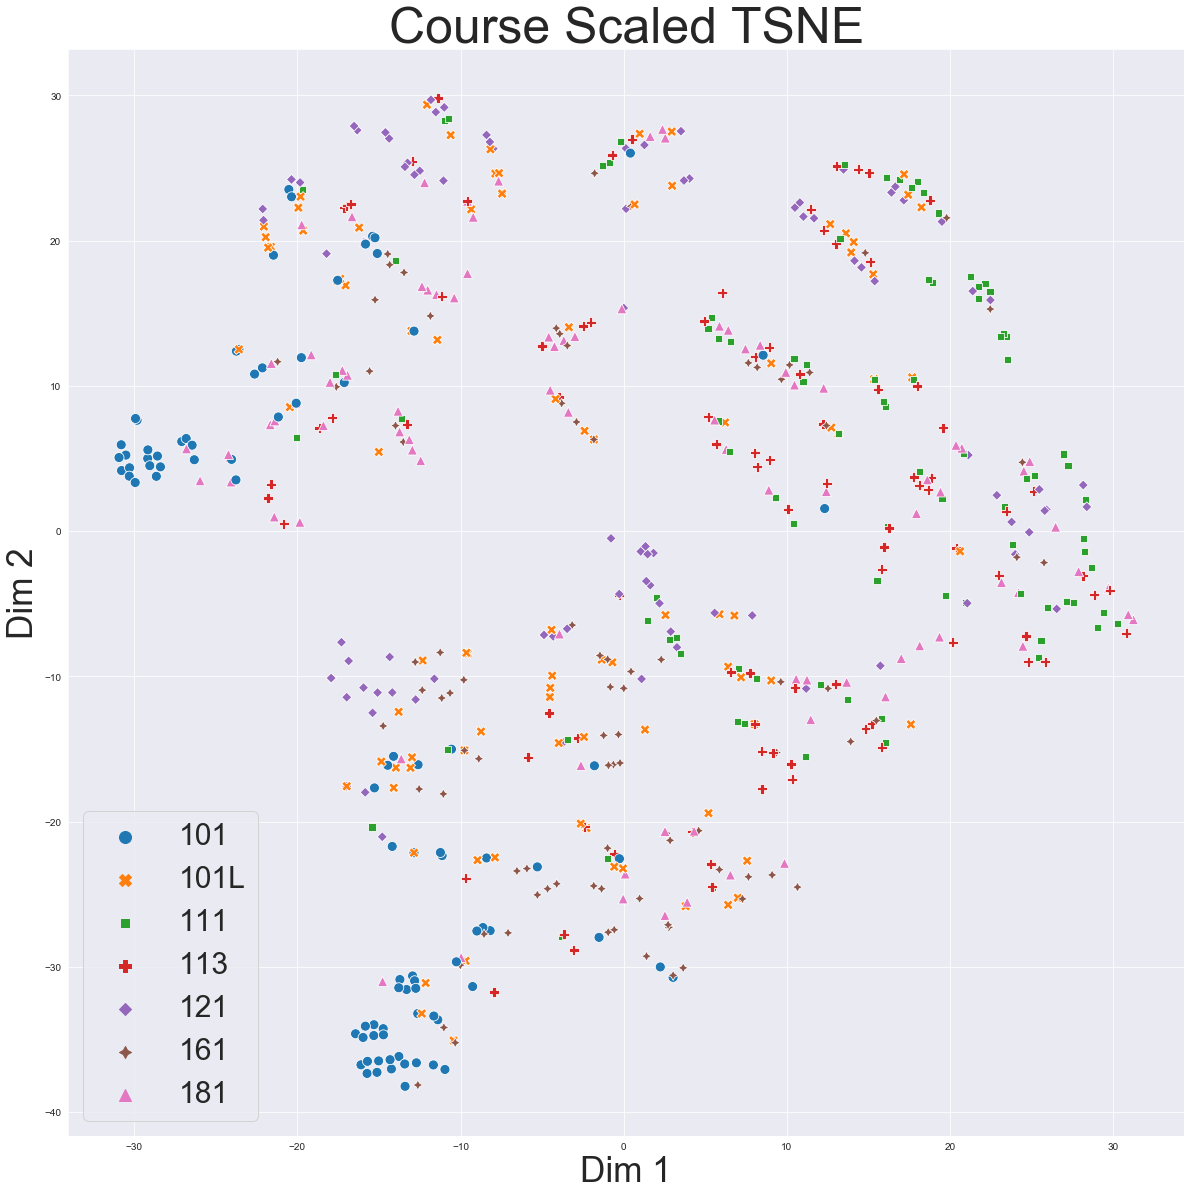

In [24]:
scaled_tsne_full = plot_courses(tnse_scaled_df, 'Course Scaled TSNE')

## TSNE Course Scatterplot (Above)
- After applying TSNE to visualize the data, some clustered courses are visible (such as 101 with 181 in the top left)
- The separation between similar clusters is hard to see since there is a lot of overlap - consider using Kmeans tp create the clusters before visualizing the data 
- Before moving to kmeans analysis, see if the data can be better graphed using PCA

## PCA Visualization
- Scale the data (again since PCA is sensitive to scale) 
- Graph using the first two principal components after applying PCA to see if better course clusterings can be identified

In [33]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

pca_pipeline = Pipeline(steps=[
    ('scale_data', StandardScaler()),
    ('labelled_pca', FunctionTransformer(create_pca))
])

In [34]:
pca_transformed_df = pca_pipeline.fit_transform(pivoted_course_df)
pca_transformed_df

0         1 course
0   -3.266866  0.743355    101
1   -1.234577  1.647494   101L
2    0.767525 -0.983315    111
3   -0.324813 -0.466620    113
4   -0.110876 -1.258666    121
..        ...       ...    ...
632  2.446581  3.335093    111
633  2.036326  4.490763    113
634 -0.672353  0.041992    121
635  2.003245  1.238197    161
636  2.928470  2.805070    181

[637 rows x 3 columns]

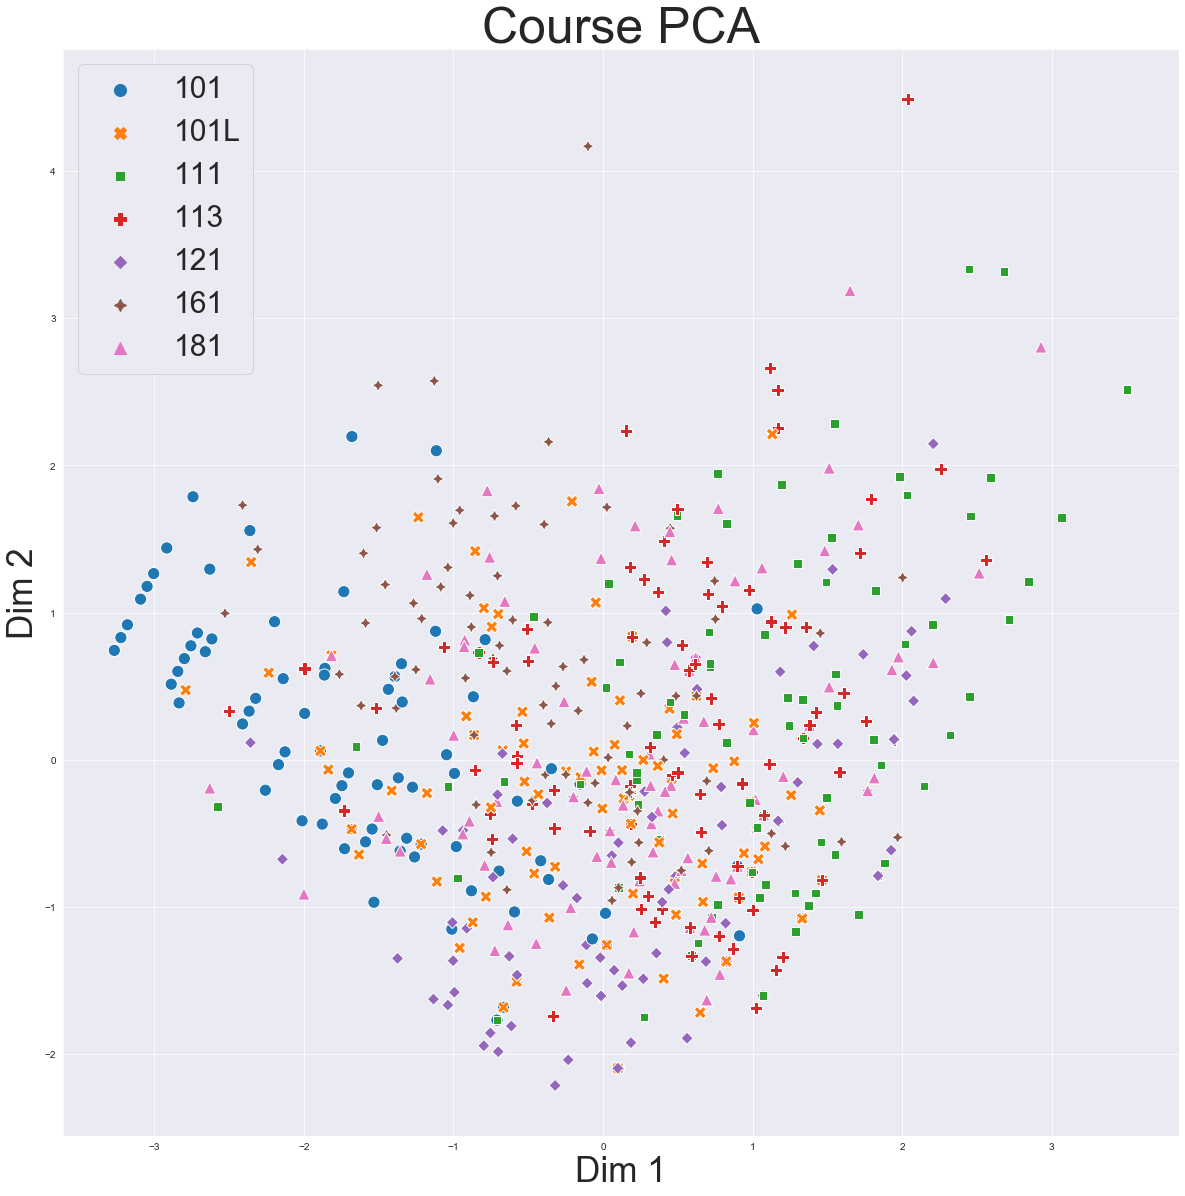

In [35]:
ax2 = plot_courses(pca_transformed_df, 'Course PCA')
ax2

## Interpret PCA Graph (Above)
- After using PCA, it does appear that there are certain sections that identify unique courses (101 is mostly near the top left; 121 near the bottom)
- Still, there is too much overlap to see any relationships between the courses (courses that are clustered similarly)
- Since PCA attempts to preserve maximum variance in the data, I can graph each course individually to see if courses have similar distributions along the principal components

In [36]:
pca_transformed_df.columns = ['PC1', 'PC2', 'course']

## Cluster in PCA Graph
- To better identify any clusters in the PCA graph, I can use kmeans with n_clusters=7 
- Why n_clusters=7? Well 7 courses are in the dataset so test n_clusters=7

In [37]:
kmeans_7 = KMeans(n_clusters=7)
pca_transformed_df['Cluster'] = kmeans_7.fit_predict(pca_transformed_df[['PC1', 'PC2']])
pca_transformed_df.head()

PC1       PC2 course  Cluster
0 -3.266866  0.743355    101        1
1 -1.234577  1.647494   101L        5
2  0.767525 -0.983315    111        0
3 -0.324813 -0.466620    113        2
4 -0.110876 -1.258666    121        4

Text(0.5, 0.98, 'Course Separated PCA')

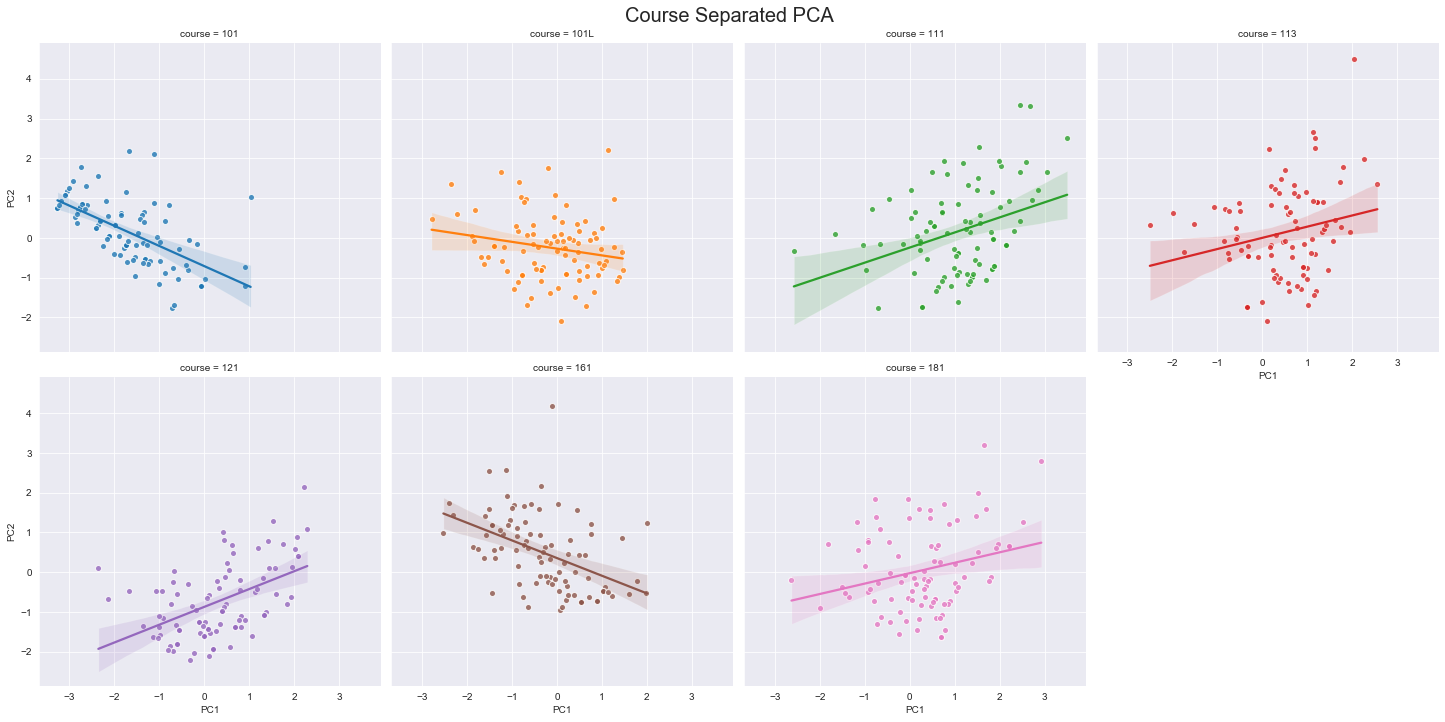

In [38]:

axs_2 = sns.lmplot(x='PC1', y='PC2', hue='course', col='course', data=pca_transformed_df, scatter_kws={"edgecolor": 'w'}, col_wrap=4, fit_reg=True)
axs_2.fig.subplots_adjust(top=0.93)
axs_2.fig.suptitle('Course Separated PCA', fontsize=20)

## Interpret Individual Courses in PCA Graph by distribution (above)
- From the graph, 101, 101L and 161 all have falling lines of best fit on the PC axes
- 121, 181, 111, 113 all have rising lines of best fit on the PC axes
- These are two groupings of courses that are potentially simialr

## PCA with Hue as Clusters
- Visualize Kmeans on the PC axes to see if the clusters relate to courses 
- Since the data is all so close, it seems to not match up too well (in the graph below)
- These kmeans clusters do not match up well from the PCA graph above 

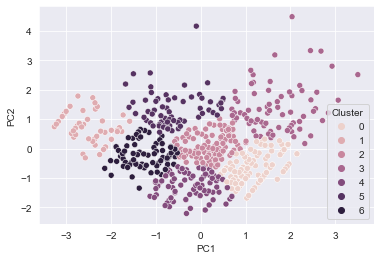

In [39]:
sns.scatterplot(x=pca_transformed_df['PC1'], y=pca_transformed_df['PC2'], hue=pca_transformed_df['Cluster'])

### Try something new
- Try to take the 4D data and do pca with n_components = {2, 3, 4}. This will attempt to reduce the dimensionality and take the axes of greatest varience of the data (transform the axes of the data)
- Use kmeans with n_clusters = 7 on after applying pca (7; 1 per course) to make a cluster label
- Graph the data after pca transformation in 2D with tsne using tsne n_components=2, hue='cluster' to find any relationships between the courses

In [44]:
# create a new PCA function that returns both the PCA model and transformed data
from typing import Tuple
def get_pca(df: pd.DataFrame, n_components=2) -> Tuple[pd.DataFrame, PCA]:
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(df))
    pca_df = pca_df.join(pd.DataFrame(inner_course_index, columns=['course']))
    return (pca, pca_df)

In [45]:
# create a parametric function to test out different combinations of pca, kmeans and tsne
def pca_w_kmeans_graph_tsne(original_df, pca_n_components, kmeans_n_clusters, tsne_n_components=2, perplexity=30):
    # apply pca on data
    pca_pipeline_n_comp = Pipeline(steps=[
        ('scale_data', StandardScaler()),
        ('labelled_pca', FunctionTransformer(get_pca, kw_args={'n_components': pca_n_components}))
    ])

    pca, pca_n_df = pca_pipeline_n_comp.fit_transform(original_df)
    pca_labels = [f'PC{i+1}' for i in range(pca_n_components)]
    labels = pca_labels + ['course']
    pca_n_df.columns=labels
    
    loadings = pd.DataFrame(
        pca.components_.T,  
        columns=pca_labels, 
        index=original_df.columns,  
    )
    # print the pc loadings to interpret the PC's
    print(loadings)

    # apply kmeans on data
    pca_n_df['cluster'] = KMeans(n_clusters=kmeans_n_clusters).fit_predict(pca_n_df[pca_labels])
    # print(pca_n_df.head())

    # if pca_n_components == 2:
    #     return pca_n_df

    # apply tsne on data to graph
    tsne_df = pd.DataFrame(TSNE(n_components=tsne_n_components, perplexity=perplexity).fit_transform(pca_n_df[pca_labels]))
    tsne_df['cluster'] = pca_n_df['cluster']
    tsne_df['course'] = inner_course_index
    tsne_labels = [f"Dim{i+1}" for i in range(tsne_n_components)] + ["cluster", "course"]
    tsne_df.columns = tsne_labels
    return tsne_df

# NOTE 1
- After experimenting with the above function, my conclusion was that PCA was not needed prior to applying TSNE
- Since there are only 4 dimensions in my data, using PCA as a dimensionality reduction technique is not necessary
- Instead, a better alternative would be to visualize the data from 4D to 2D with TSNE (no PCA before) and clustering the 4D data using Kmeans
- **Important**: You should not try to cluster with kmeans after applying tsne because tsne does not preserve distance (and kmeans is a distance based 
algorithm)
- The function below will first apply tsne for visualizations and then create clusters using kmeans (since similar courses can be found in similar clusters)

In [46]:
def kmeans_graph_tsne(original_df, kmeans_n_clusters, tsne_n_components=2, perplexity=30):
    # apply kmeans on data
    original_df = pd.DataFrame(StandardScaler().fit_transform(original_df))
    original_df.columns = ['avg', 'lect_watched', 'difficulty', 'usefulness']
    # print(original_df)
    # original_df = original_df.reset_index()
    original_df['cluster'] = KMeans(n_clusters=kmeans_n_clusters).fit_predict(original_df)
    # print(original_df.head())

    # if pca_n_components == 2:
    #     return pca_n_df

    # apply tsne on data to graph
    tsne_df = pd.DataFrame(TSNE(n_components=tsne_n_components, perplexity=perplexity).fit_transform(original_df[['avg', 'lect_watched', 'difficulty', 'usefulness']]))
    # tsne_df['cluster'] = original_df['cluster']
    tsne_df['course'] = inner_course_index
    tsne_df['cluster'] = original_df['cluster']
    tsne_labels = [f"Dim{i+1}" for i in range(tsne_n_components)] + ["course", 'cluster']
    tsne_df.columns = tsne_labels
    return tsne_df

# Note 2
- Before trying out the tsne and kmeans function above, I wanted be sure that I was using the correct n_clusters value for kmeans  
- One method for determining the correct n_clusters value is to apply the elbow method: the 'elbow' of the graph should be the n_clusters value 
- I will use the yellowbrick library to make this visualization for me

In [47]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
def vizualize_n_clusters_kmeans(original_df, metric="distortion", timings=True, locate_elbow=True):
    # scale the data
    original_df = pd.DataFrame(StandardScaler().fit_transform(original_df))
    original_df.columns = ['avg', 'lect_watched', 'difficulty', 'usefulness']
    # apply kelbowvissualizer with a specific algo
    vizualizer = KElbowVisualizer(KMeans(), k=(2, 15), metric=metric, timings=timings, locate_elbow=locate_elbow)
    vizualizer.fit(original_df)
    return vizualizer

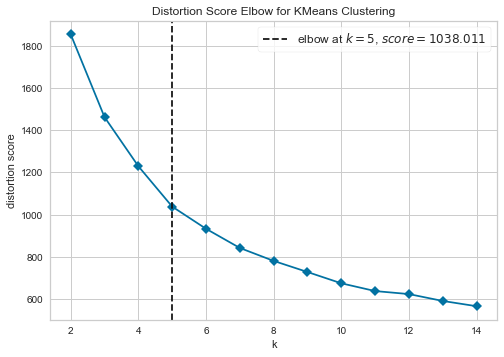

In [48]:
# look at the optimal cluster number for kmeans
vizualize_n_clusters_kmeans(pivoted_course_df, timings=False).show()

## Elbow method: Findings (Above)
- After looking at the elbow method results, the n_clusters value has come out as 5
- Unfortunately, this graph does not have a clear 'elbow' so another method should be used to confirm the n_clusters value

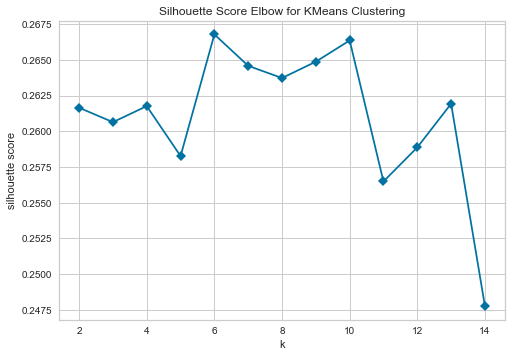

In [49]:
vizualize_n_clusters_kmeans(pivoted_course_df, metric='silhouette', timings=False, locate_elbow=False).show()

## Silhoutte Method: Findings
- Since the elbow method did not work, I can use the Silhoutte scores method to find what value of n gives me the most similarity between points of the same cluster, and difference between different clusters 
- The Silhoutte scores can change when they are re-run. In the graph above, an n_clusters value of 6 is suggested for silhouette scores but after running it multiple times, n_clusters values between 6-8 are commonly suggested 
- 8 looks too far to be the 'elbow' of the graph in the inital elbow method so I will choose n_clusters as 7 (since it is the elbow for the elbow method and has scored the top silhouette score) 

Text(0.5, 1.0, 'Courses TSNE 4D > 2D')

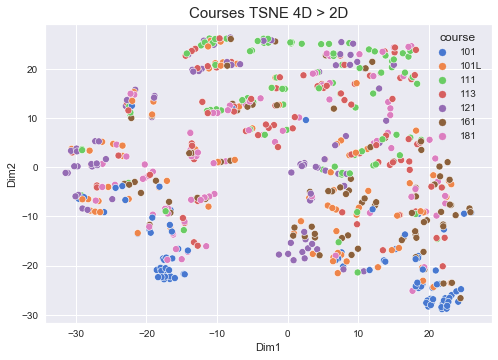

In [51]:
sns.set_style('darkgrid')
tsne_kmeans_df = kmeans_graph_tsne(pivoted_course_df, 7, perplexity=27)
tsne_course = sns.scatterplot(data=tsne_kmeans_df, x='Dim1', y='Dim2', hue='course', palette='muted')
tsne_course.set_title('Courses TSNE 4D > 2D', fontsize=15)

## TSNE Findings By Course (Above)
- From the above graph, similar courses are grouped together
- It is still hard to see what coruses are related so I will use kmeans to make 7 clusters for me 
- **Note: For more explanations on this section, refer to the slides**

Text(0.5, 1.0, 'Cluster TSNE 4D > 2D')

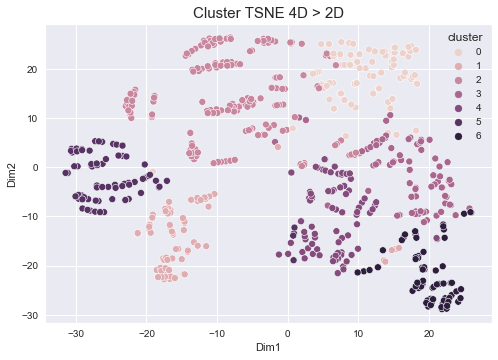

In [52]:
tsne_cluster = sns.scatterplot(data=tsne_kmeans_df, x='Dim1', y='Dim2', hue='cluster')
tsne_cluster.set_title('Cluster TSNE 4D > 2D', fontsize=15)

## TSNE findings by Cluster (Above)
- Kmeans has been able to identify 7 optimal clusters 
- Each of these clusters can be split individually and points in the cluster can be plotted using TSNE to visualize courses in each cluster (below)

Text(0.5, 0.98, 'Courses By Cluster TSNE')

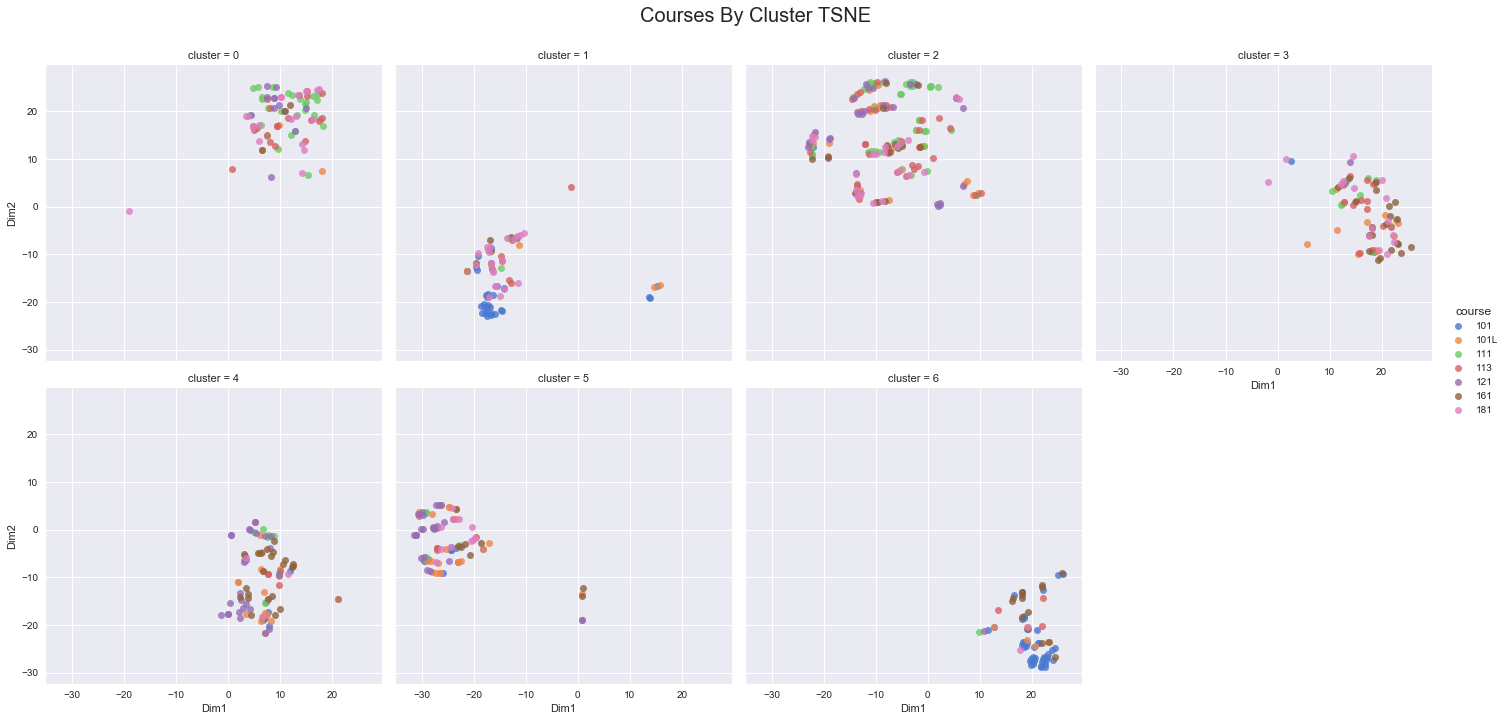

In [60]:
course_by_cluser = sns.lmplot(x='Dim1', y='Dim2', hue='course', col='cluster', data=tsne_kmeans_df, scatter_kws={"edgecolor": 'w'}, col_wrap=4, fit_reg=False, palette='muted')
course_by_cluser.fig.subplots_adjust(top=0.9)
course_by_cluser.fig.suptitle('Courses By Cluster TSNE', fontsize=20)

## Courses By Clusters: Findings
- Each cluster above contains similar courses 
- Since there are many courses in a single cluster, it can be hard to see the results 
- Sort the result data so that it is simple to see the clusters

In [54]:
import collections
def add_to_cluster_count(row, cluster_count):
    if cluster_count.get(row['cluster']) == None:
        cluster_count[row['cluster']] = {row['course']: 1}
    else:
        if cluster_count[row['cluster']].get(row['course']) == None:
            cluster_count[row['cluster']][row['course']] = 1
        else:
            cluster_count[row['cluster']][row['course']] += 1
test_dict = {}
tsne_kmeans_df.apply(add_to_cluster_count, axis=1, args=(test_dict, ))
# print(collections.OrderedDict(sorted(test_dict.items())))
print(test_dict)

{6: {'101': 40, '181': 2, '161': 15, '113': 3, '101L': 5, '121': 1, '111': 1}, 3: {'101L': 13, '161': 21, '181': 15, '111': 9, '113': 16, '121': 2, '101': 2}, 2: {'111': 39, '113': 33, '101L': 25, '121': 27, '161': 17, '181': 22, '101': 2}, 4: {'113': 6, '121': 26, '161': 22, '101': 6, '111': 8, '101L': 19, '181': 3}, 0: {'121': 12, '111': 27, '113': 20, '181': 18, '101L': 3, '161': 3}, 1: {'101': 32, '161': 5, '181': 20, '113': 6, '111': 3, '101L': 5}, 5: {'161': 8, '101L': 21, '113': 7, '121': 23, '111': 4, '181': 11, '101': 9}}


In [55]:
from typing import Dict
def sort_dict(curr_dict) -> Dict[str, int]:
    # BC, only single dict remains; this is the course dict
    if curr_dict.get('121') != None or curr_dict.get('101L') != None:
        sorted_curr_dict = {course: count for course, count in sorted(curr_dict.items(), key=lambda dict_item: dict_item[1])}
        return sorted_curr_dict 
    
    # not in a leaf dict, iterate through all dicts and sort the leaves
    unsorted_full_dict = {}
    for key, inner_dict in curr_dict.items():
        unsorted_full_dict[key] = sort_dict(inner_dict)
    
    return collections.OrderedDict(sorted(unsorted_full_dict.items()))
ordered_dict = sort_dict(test_dict)
print(ordered_dict)

OrderedDict([(0, {'101L': 3, '161': 3, '121': 12, '181': 18, '113': 20, '111': 27}), (1, {'111': 3, '161': 5, '101L': 5, '113': 6, '181': 20, '101': 32}), (2, {'101': 2, '161': 17, '181': 22, '101L': 25, '121': 27, '113': 33, '111': 39}), (3, {'121': 2, '101': 2, '111': 9, '101L': 13, '181': 15, '113': 16, '161': 21}), (4, {'181': 3, '113': 6, '101': 6, '111': 8, '101L': 19, '161': 22, '121': 26}), (5, {'111': 4, '113': 7, '161': 8, '101': 9, '181': 11, '101L': 21, '121': 23}), (6, {'121': 1, '111': 1, '181': 2, '113': 3, '101L': 5, '161': 15, '101': 40})])


## Sorted Clustered Data: Results
- The above ordered dict has the sorted courses by cluster made by a **recursive function**
- To see the findings from the sorted dict/graphing by cluster, refer to the report slide titled **Finding Similar Courses (Continued)**
- The slide referenced above makes conclusions based on previous knowledge about what courses are similar

## Use the initial PCA + TSNE + Kmeans function to examine the principal components (PC; below)
- The principal component loadings can be used for feature engineering/to extract meaning from the data
- PC1: Courses with lower averages, that are difficult, had a high percentage of lectures watched, and were more useful
- PC2: Courses with lower averages, that had a low percentage of lectures watched, were difficult, and were not useful
- PC3: Courses that had higher averages, a lower percentage of lectures watched, were more difficult, and were more useful
- PC4: Courses that had lower averages, were more difficult and were more useful

                   PC1       PC2       PC3       PC4
avg          -0.372057 -0.738626  0.244834 -0.506026
lect_watched  0.471116 -0.443518 -0.759552 -0.066503
difficulty   -0.603997 -0.266160 -0.280243  0.697001
usefulness    0.524224 -0.432299  0.533481  0.503691


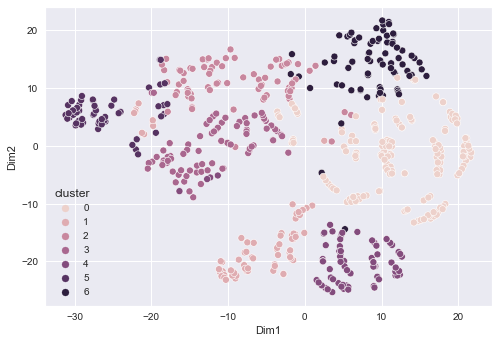

In [59]:
test = pca_w_kmeans_graph_tsne(pivoted_course_df, 4, 7, perplexity=35)
sns.scatterplot(data=test, x='Dim1', y='Dim2', hue='cluster')